In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os


# os.chdir('/eos/user/p/phbelang/Programming/Octupoles_Guido/')

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
# if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
#     raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')



import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
sys.path.append('/home/pbelanger/ABPlocal/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst



# def load_tracked(line_ID,sf=10):
#     tracked = {}
#     for label in ['ref','HO','LR','OCTU']:
#         tracked[label] = pd.read_pickle(f'Tracking/tracked_{label}_sf{sf}_{line_ID}.pkl')
#     tracked['coord'] = pd.read_pickle(f'Tracking/coordinates_{line_ID}.pkl')
#     tracked['sf'] = sf
#     return tracked

def load_tracked(line_ID,sf=10):
    tracked = {}
    for label in ['ref','HO','LR','OCTU','BBCW']:
        tracked[label] = pd.read_pickle(f'Tracking/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'Tracking/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf
    _coord = tracked['coord']
    ctour_idx  = list(_coord[_coord['theta_sig'] == np.min(_coord['theta_sig'])].index)
    ctour_idx += list(_coord[_coord['r_sig'] == np.max(_coord['r_sig'])].index)[1:-1]
    ctour_idx += list(_coord[_coord['theta_sig'] == np.max(_coord['theta_sig'])].index)[::-1]
    ctour_idx += list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)[1:-1][::-1]
    tracked['ctour_idx'] = ctour_idx
    return tracked



def sum_footprints(_tracked,components,contour = False,at_intensity = None,at_current = None,at_mo_current = None):
    dQx,dQy = np.zeros(len(_tracked['coord'])),np.zeros(len(_tracked['coord']))

    rescale = {'HO':1,'LR':1,'BBCW':1,'OCTU':1}
    if at_intensity is not None:
        rescale['HO'] = at_intensity/1.4e11
        rescale['LR'] = at_intensity/1.4e11
    if at_current is not None:
        rescale['BBCW'] = at_current/350
    if at_mo_current is not None:
        rescale['OCTU'] = at_mo_current/-550

    for i in components:
    #---------------
        _dQx = _tracked[i].tunes_n['Qx'] - _tracked['ref'].tunes_n['Qx']
        _dQy = _tracked[i].tunes_n['Qy'] - _tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*_tracked['sf']*rescale[i]
        dQy += _dQy*_tracked['sf']*rescale[i]
    #---------------


    if contour:

        dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    
    return dQx,dQy


def octupole_footprint(_tracked,_mo_df,gamma0,contour=False):

    dQx,dQy = np.zeros(len(_tracked['coord'])),np.zeros(len(_tracked['coord']))

    for idx,mo in _mo_df.iterrows():
        #---------------
        _dQx,_dQy = dtune.DQx_DQy_octupole( _tracked['coord']['x_sig'],
                                            _tracked['coord']['y_sig'],
                                            betxy   = mo[['betx','bety']],
                                            emittxy = np.array([2.3e-6,2.3e-6])/gamma0,
                                            k1l     = 0,
                                            k3l     = mo['k3l'])


        dQx += _dQx
        dQy += _dQy
        #---------------

    if contour:
        dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    
    return dQx,dQy


LINEFOLDER = './Lines/'
def import_from_lines(line_ID,to_track='b4'):
    line   = {}
    twiss  = {}
    survey = {}
    tracker_b1 = None
    tracker_b4 = None
    for seq in ['lhcb4']:
        _beam = seq[-2:]
        # Importing Line
        line[_beam] = xPlus.importLine(LINEFOLDER + f'line_{line_ID}_{seq}.json')
        
        # Importing twiss and tracker
        if _beam == 'b1':
            tracker_b1    = xt.Tracker(line=line[_beam])
            twiss[_beam]  = tracker_b1.twiss().to_pandas(index="name")
            survey[_beam] = tracker_b1.survey().to_pandas(index="name")
        elif _beam == 'b4':
            tracker_b4    = xt.Tracker(line=line[_beam])
            twiss[_beam]   = tracker_b4.twiss().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().to_pandas(index="name")

            _beam = 'b2'
            twiss[_beam]   = tracker_b4.twiss().reverse().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().reverse().to_pandas(index="name")


    if to_track == 'b1':
        tracker = tracker_b1
        del tracker_b4
    else:
        tracker = tracker_b4
        del tracker_b1
    # Clearing xsuite ouput
    clear_output(wait=False)



    allVars = list(tracker.vars._owner.keys())
    allElements = list(tracker.element_refs._owner.keys())


    # Deactivating all wires
    #===================================================
    tracker.vars['enable_qff'] = 0
    for IP in ['ip1','ip5']:
        tracker.vars[f"bbcw_rw_{IP}.{_beam}"] = 1
        tracker.vars[f"bbcw_i_{IP}.{_beam}"]  = 0
    run3_wires = [name for name in allElements if ('bbcw' in name)&('wire' in name)]
    for wire in run3_wires:
        tracker.line.element_dict[wire].post_subtract_px  = 0
        tracker.line.element_dict[wire].post_subtract_py  = 0
        
    # Creating BB knobs
    #===================================================
    
    for _ip in ['ip1','ip5','ip2','ip8']:
        bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}{_beam}' in name)]
        bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}{_beam}' in name)]

        # New knob:
        tracker.vars[f'{_ip}_bblr_ON'] = 1
        tracker.vars[f'{_ip}_bbho_ON'] = 1

        # Linking to new knob 
        for _lr in bb_lr:
            # Infividual knobs
            tracker.vars[f'{_lr}_ON'] = 1
            tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value

        for _ho in bb_ho:
            tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value

    for _ip in ['ip1','ip5','ip2','ip8']:
        tracker.vars[f'{_ip}_bblr_ON'] = 0
        tracker.vars[f'{_ip}_bbho_ON'] = 0


    # Creating sext and oct knobs
    #====================================================

    # AS DONE IN THE MASK
    #---------------------
    part = tracker.line.particle_ref
    brho = part.p0c[0]/(part.q0*cst.c)
    tracker.vars['I_oct'] = 0
    for ss in '12 23 34 45 56 67 78 81'.split():
        tracker.vars[f'kof.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
        tracker.vars[f'kod.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
    #---------------------

    
    ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
    ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

    tracker.vars['all_oct_ON']  = 1
    tracker.vars['all_sext_ON'] = 1
    for _ks in ks:
        if tracker.vars[_ks]._expr is None:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
        else:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
    for _ko in ko:
        if tracker.vars[_ko]._expr is None:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
        else:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

    return tracker,line,twiss,survey




---
# Coordinates
---

(-0.24161608294902936,
 6.800037847942206,
 -0.24161608294902942,
 6.800037847942206)

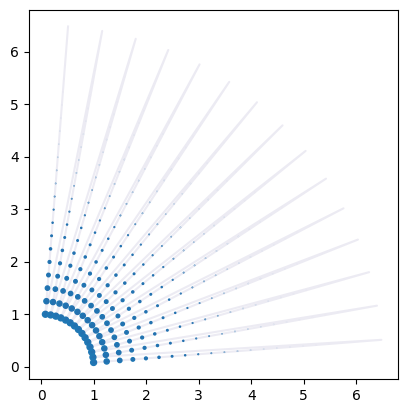

In [3]:
line_ID = 'NEG'
tracked = load_tracked_FULL(line_ID )


plt.figure()
plt.plot(tracked['coord']['x_sig'],tracked['coord']['y_sig'],alpha=0.1,color='darkslateblue')
plt.scatter(tracked['coord']['x_sig'],tracked['coord']['y_sig'],s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
#plt.legend()

---
# FOOTPRINT with Analytic
---

In [2]:
%pwd

'/eos/user/p/phbelang/Programming/FPCatalogue'

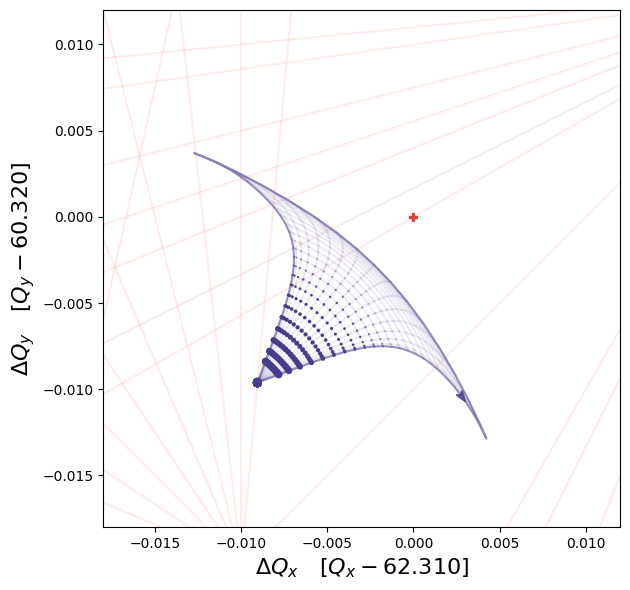

In [2]:
window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]

tracked = load_tracked('base')

color = 'darkslateblue'
plt.figure(figsize=(8,6))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)

dQx,dQy = sum_footprints(tracked,components = ['HO','LR'],at_mo_current=430)


bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)


dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3

plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)


plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)


plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()


---
# Importing Line
---

NameError: name 'load_tracked_FULL' is not defined

In [7]:
tracker,line,twiss,survey = import_from_lines('base')

tracked = load_tracked('base')

allVars = list(tracker.vars._owner.keys())
allElements = list(tracker.element_refs._owner.keys())

# Updating twiss
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

I_oct = 430
tracker.vars['I_oct'] = I_oct
#==========================

_beam = 'b4'
twiss[_beam]   = tracker.twiss().to_pandas(index="name")
survey[_beam]  = tracker.survey().to_pandas(index="name")

_beam = 'b2'
twiss[_beam]   = tracker.twiss().reverse().to_pandas(index="name")
survey[_beam]  = tracker.survey().reverse().to_pandas(index="name")

for _beam in ['b2','b4']:
    twiss[_beam] = xPlus.filter_twiss(twiss[_beam],entries=['drift','..'])


def octupoles_df():
    all_octu = [name for name in allElements if 'mo.' in name]
    _dict = {   'Elements'  : [],
                'kof_knob'  : [],
                'k3l'       : [],
                's'         : [],
                'betx'      : [],
                'bety'      : [],
                'betx/bety' : []}
    for el in all_octu:
        _dict['Elements'].append(el)
        knobs = tracker.element_refs[el].knobs(render=False)
        _dict['kof_knob'].append(sorted(knobs)[0])
        _dict['k3l'].append(tracker.element_refs[el].knl[3]._value)
        
        s,betx,bety = twiss['b2'].loc[el,['s','betx','bety']]
        _dict['s'].append(s)
        _dict['betx'].append(betx)
        _dict['bety'].append(bety)
        _dict['betx/bety'].append(betx/bety)

    return pd.DataFrame(_dict)


mo_df  = octupoles_df()
part   = tracker.line.particle_ref
gamma0 = part.gamma0[0]

In [3]:
mo_df.head(10)

,Elements,kof_knob,k3l,s,betx,bety,betx/bety
0,mo.22l3.b2,kod.a23b2,4.175881,25631.856217,32.359617,175.933157,0.183931
1,mo.24l3.b2,kod.a23b2,4.175881,25524.953249,32.360836,175.908863,0.183964
2,mo.25l3.b2,kof.a23b2,4.175881,25471.501765,173.936543,34.122379,5.097433
3,mo.26l3.b2,kod.a23b2,4.175881,25418.050281,32.359601,175.927097,0.183938
4,mo.28l3.b2,kod.a23b2,4.175881,25311.147313,32.361091,175.915069,0.183959
5,mo.29l3.b2,kof.a23b2,4.175881,25257.695829,173.936308,34.122008,5.097482
6,mo.30l3.b2,kod.a23b2,4.175881,25204.244345,32.359670,175.920601,0.183945
7,mo.31l3.b2,kof.a23b2,4.175881,25150.792860,173.936138,34.135824,5.095413
8,mo.32l3.b2,kod.a23b2,4.175881,25097.341376,32.360756,175.921604,0.183950
9,mo.33l3.b2,kof.a23b2,4.175881,25043.889892,173.936215,34.121933,5.097490


In [4]:
mo_df.to_pickle('/home/phbelang/mo_df.pkl')

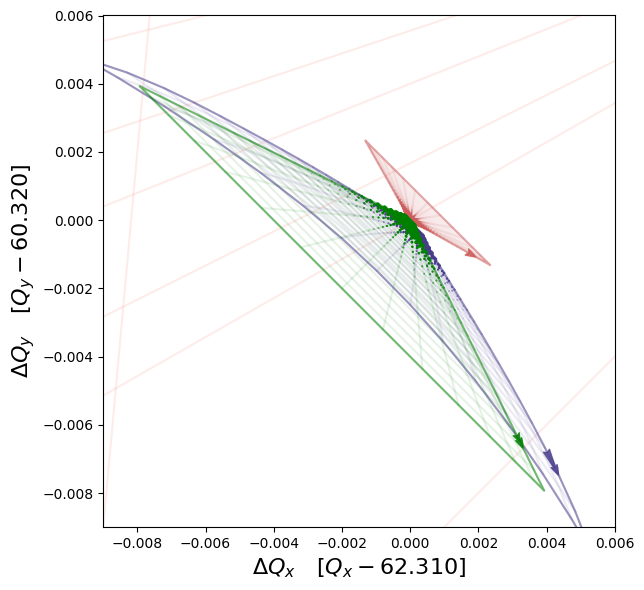

In [9]:




# Updating twiss
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

I_oct = 430
tracker.vars['I_oct'] = I_oct
#==========================
mo_df  = octupoles_df()


window    = 0.015
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]



plt.figure(figsize=(8,6))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)




#==================================
# TRACKING
color = 'darkslateblue'

dQx,dQy = sum_footprints(tracked,components = ['LR'],at_mo_current=430)
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#====================================

#==================================
# Analytic
color = 'indianred'

dQx,dQy = octupole_footprint(tracked,mo_df,gamma0,contour=False)
dQx,dQy = dQx,dQy 
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#==================================


#================================
# Single Octupole
r=1
betx=100
color = 'green'
dQx, dQy = dtune.DQx_DQy_octupole( tracked['coord']['x_sig'],
                                   tracked['coord']['y_sig'],
                                   betxy   = [betx,betx/r],
                                   emittxy = np.array([2.3e-6,2.3e-6])/gamma0,
                                   k1l     = 0,
                                   k3l     = 3000)
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#================================

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)


plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()


In [6]:
mo_df

,Elements,kof_knob,k3l,s,betx,bety,betx/bety
0,mo.22l3.b2,kod.a23b2,4.175881,25631.856217,32.359617,175.933157,0.183931
1,mo.24l3.b2,kod.a23b2,4.175881,25524.953249,32.360836,175.908863,0.183964
2,mo.25l3.b2,kof.a23b2,4.175881,25471.501765,173.936543,34.122379,5.097433
3,mo.26l3.b2,kod.a23b2,4.175881,25418.050281,32.359601,175.927097,0.183938
4,mo.28l3.b2,kod.a23b2,4.175881,25311.147313,32.361091,175.915069,0.183959
...,...,...,...,...,...,...,...
163,mo.28r3.b2,kof.a34b2,4.175881,1343.716887,173.956300,34.132359,5.096522
164,mo.26r3.b2,kof.a34b2,4.175881,1236.810919,173.937709,34.122145,5.097502
165,mo.25r3.b2,kod.a34b2,4.175881,1183.359435,32.359942,175.921226,0.183946
166,mo.24r3.b2,kof.a34b2,4.175881,1129.907951,173.942159,34.135714,5.095606


---
# Family Grouping
---

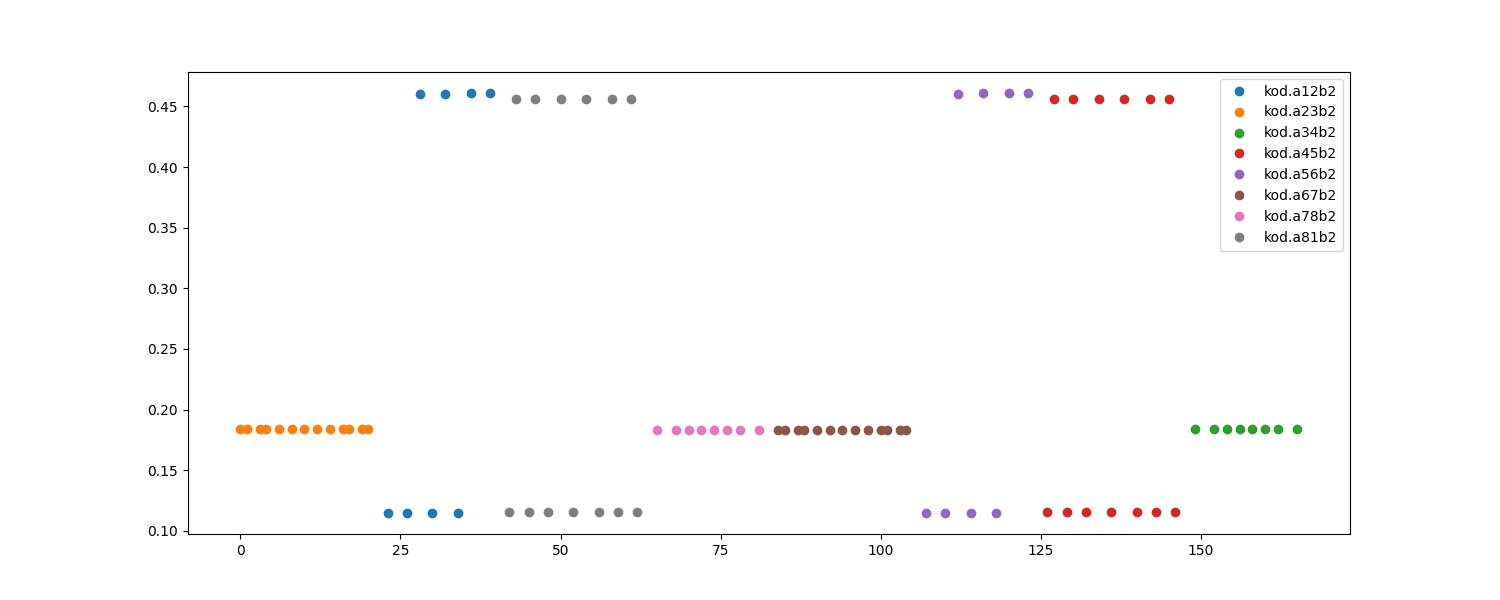

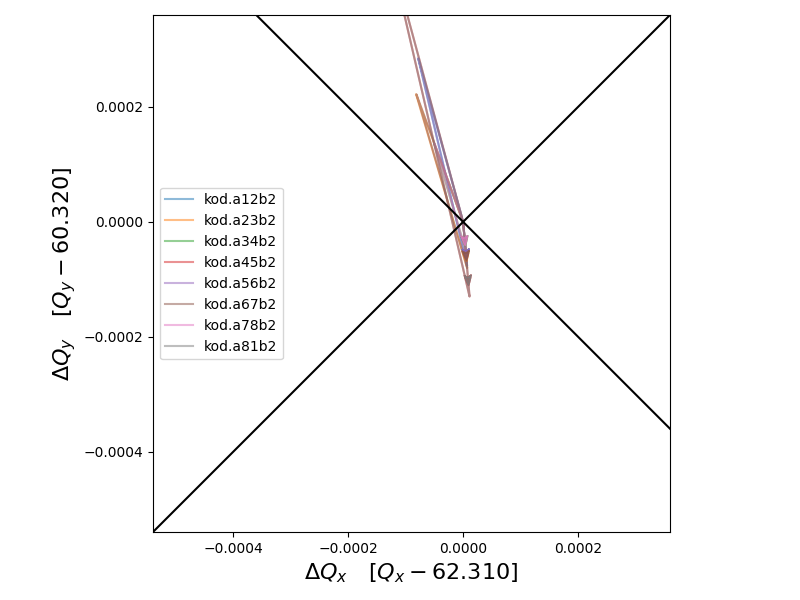

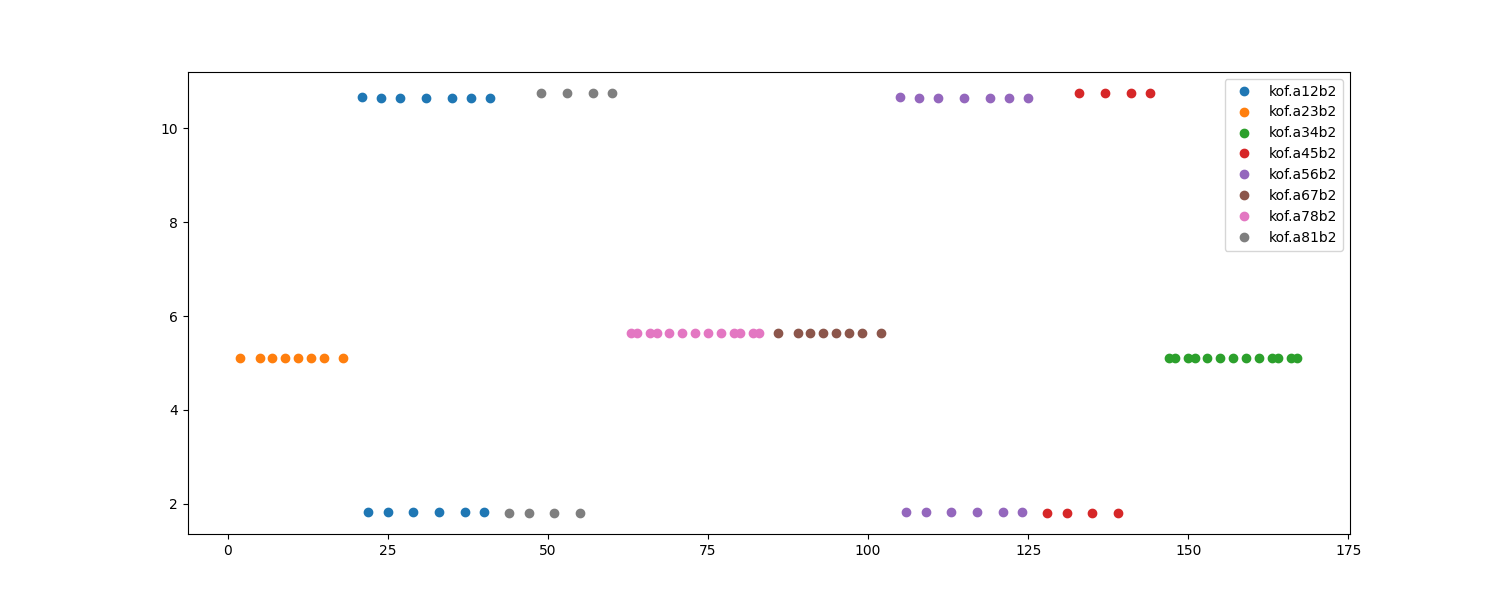

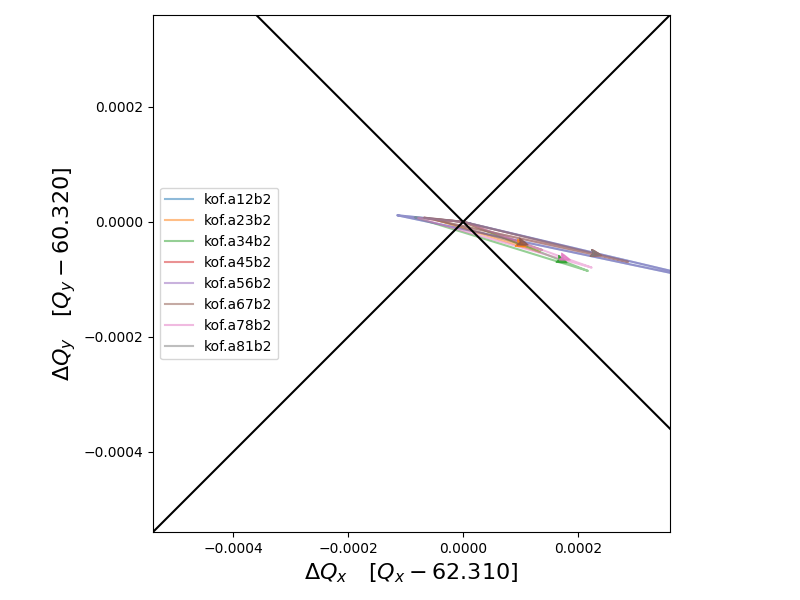

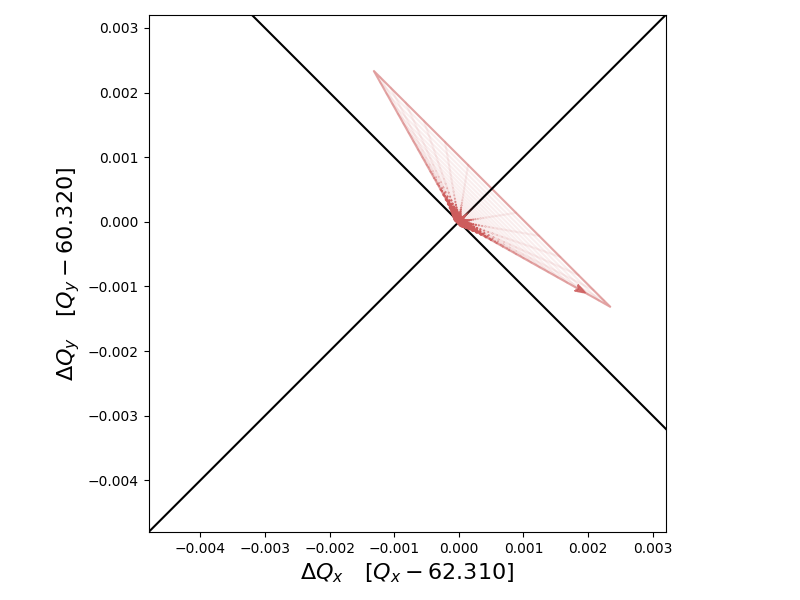

In [10]:




# Updating twiss
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1

I_oct = 430
tracker.vars['I_oct'] = I_oct
#==========================
mo_df  = octupoles_df()


window    = 0.0009
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]



plt.figure(figsize=(15,6))
for name,group in mo_df.groupby('kof_knob'):
    if 'kof' in name:
        continue
    plt.plot(group['betx/bety'],'o',label=name)
plt.legend()




plt.figure(figsize=(8,6))


#==================================
# Analytic


for name,group in mo_df.groupby('kof_knob'):
    if 'kof' in name:
        continue
    dQx,dQy = octupole_footprint(tracked,group,gamma0,contour=True)
    # dQx,dQy = 50*dQx,50*dQy
    start,stop = len(dQx)//4,len(dQx)//4+3
    plt.plot(dQx,dQy,'-',alpha=0.5,label=name)
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=plt.gca().lines[-1].get_color(),alpha=0.8,label = None,zorder=100)
#==================================
plt.legend()

plt.plot([-1,1],[-1,1],color='k')
plt.plot([-1,1],[1,-1],color='k')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)



plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()


plt.figure(figsize=(15,6))
for name,group in mo_df.groupby('kof_knob'):
    if 'kod' in name:
        continue
    plt.plot(group['betx/bety'],'o',label=name)
plt.legend()




plt.figure(figsize=(8,6))


#==================================
# Analytic


for name,group in mo_df.groupby('kof_knob'):
    if 'kod' in name:
        continue
    dQx,dQy = octupole_footprint(tracked,group,gamma0,contour=True)
    # dQx,dQy = 50*dQx,50*dQy
    start,stop = len(dQx)//4,len(dQx)//4+3
    plt.plot(dQx,dQy,'-',alpha=0.5,label=name)
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=plt.gca().lines[-1].get_color(),alpha=0.8,label = None,zorder=100)
#==================================
plt.legend()
plt.plot([-1,1],[-1,1],color='k')
plt.plot([-1,1],[1,-1],color='k')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)


plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()





window    = 0.008
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]



plt.figure(figsize=(8,6))




#==================================
# Analytic
color = 'indianred'

dQx,dQy = octupole_footprint(tracked,mo_df,gamma0,contour=False)
dQx,dQy = dQx,dQy 
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#==================================

plt.plot([-1,1],[-1,1],color='k')
plt.plot([-1,1],[1,-1],color='k')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)

plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()

In [18]:
np.linspace(-10,10,100)

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

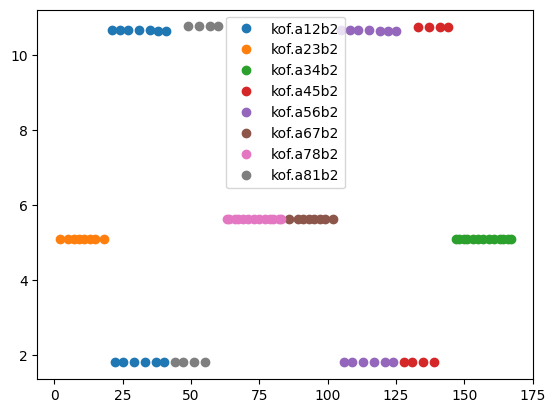

In [10]:
plt.figure()
for name,group in mo_df.groupby('kof_knob'):
    if 'kod' in name:
        continue
    plt.plot(group['betx/bety'],'o',label=name)
plt.legend()

,Elements,kof_knob,k3l,s,betx,bety,betx/bety
0,mo.22l3.b2,kod.a23b2,-2000.0,25631.856217,100.0,40.0,2.5
1,mo.24l3.b2,kod.a23b2,-2000.0,25524.953249,40.0,100.0,2.5
2,mo.25l3.b2,kof.a23b2,0.0,25471.501765,100.0,100.0,2.5
3,mo.26l3.b2,kod.a23b2,0.0,25418.050281,40.0,40.0,2.5


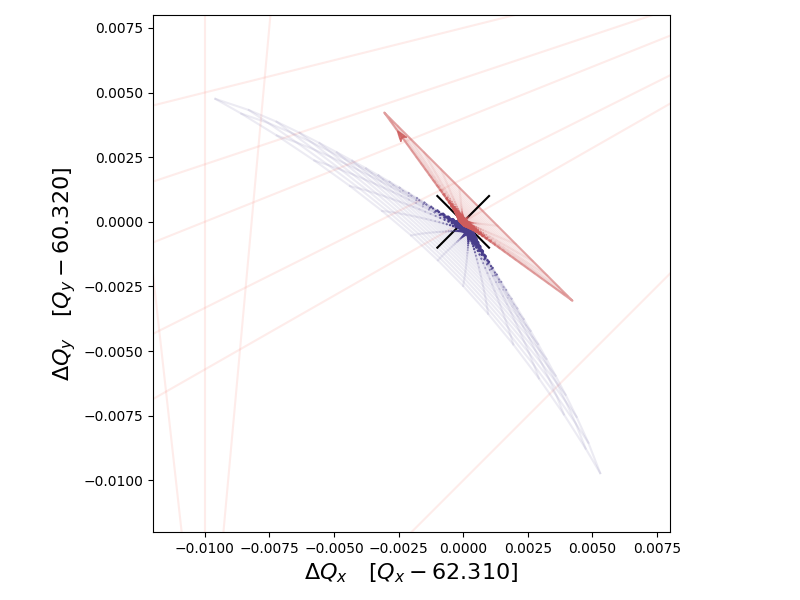

In [14]:

r = 2.5
base_beta = 100

mo_test = mo_df.loc[:3].copy()

mo_test.loc[0,'k3l'] = -10000/2
mo_test.loc[1,'k3l'] = -10000/5
mo_test.loc[2,'k3l'] = 0#5000/2
mo_test.loc[3,'k3l'] = 0#20000/2

mo_test.loc[0,'betx'] = base_beta
mo_test.loc[1,'betx'] = mo_test.loc[0,'betx']/r
mo_test.loc[2,'betx'] = base_beta
mo_test.loc[3,'betx'] = mo_test.loc[0,'betx']/r


mo_test['betx/bety'] = r
mo_test.loc[0,'bety'] = mo_test.loc[0,'betx']/r
mo_test.loc[1,'bety'] = mo_test.loc[1,'betx']*r
mo_test.loc[2,'bety'] = mo_test.loc[0,'betx']#/r
mo_test.loc[3,'bety'] = mo_test.loc[1,'betx']#*r
display(mo_test)


window    = 0.02
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]



plt.figure(figsize=(8,6))
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)


#==================================
# TRACKING
color = 'darkslateblue'

dQx,dQy = sum_footprints(tracked,components = ['LR'],at_mo_current=430)
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

# dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
# start,stop = len(dQx)//4,len(dQx)//4+3
# plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
# bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#====================================

#==================================
# Analytic
color = 'indianred'

_dQx,_dQy = octupole_footprint(tracked,mo_test,gamma0,contour=False)
dQx,dQy = _dQx,_dQy 
# bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
# plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

# dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
# start,stop = len(dQx)//4,len(dQx)//4+3
# plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
# bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
# #==================================

bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
start,stop = len(dQx)//4,len(dQx)//4+3
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)
#====================================

plt.plot([-1e-3,1e-3],[-1e-3,1e-3],color='k')
plt.plot([-1e-3,1e-3],[1e-3,-1e-3],color='k')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)


plt.xlabel(rf'$\Delta Q_x\quad [Q_x - {Qx_0+62:.3f}]$',fontsize=16)
plt.ylabel(rf'$\Delta Q_y\quad [Q_y - {Qy_0+60:.3f}]$',fontsize=16)

plt.tight_layout()

In [73]:
mo_df

,Elements,kof_knob,k3l,s,betx,bety,betx/bety
0,mo.22l3.b2,kod.a23b2,4.175881,25631.856217,32.359617,175.933157,0.183931
1,mo.24l3.b2,kod.a23b2,4.175881,25524.953249,32.360836,175.908863,0.183964
2,mo.25l3.b2,kof.a23b2,4.175881,25471.501765,173.936543,34.122379,5.097433
3,mo.26l3.b2,kod.a23b2,4.175881,25418.050281,32.359601,175.927097,0.183938
4,mo.28l3.b2,kod.a23b2,4.175881,25311.147313,32.361091,175.915069,0.183959
...,...,...,...,...,...,...,...
163,mo.28r3.b2,kof.a34b2,4.175881,1343.716887,173.956300,34.132359,5.096522
164,mo.26r3.b2,kof.a34b2,4.175881,1236.810919,173.937709,34.122145,5.097502
165,mo.25r3.b2,kod.a34b2,4.175881,1183.359435,32.359942,175.921226,0.183946
166,mo.24r3.b2,kof.a34b2,4.175881,1129.907951,173.942159,34.135714,5.095606


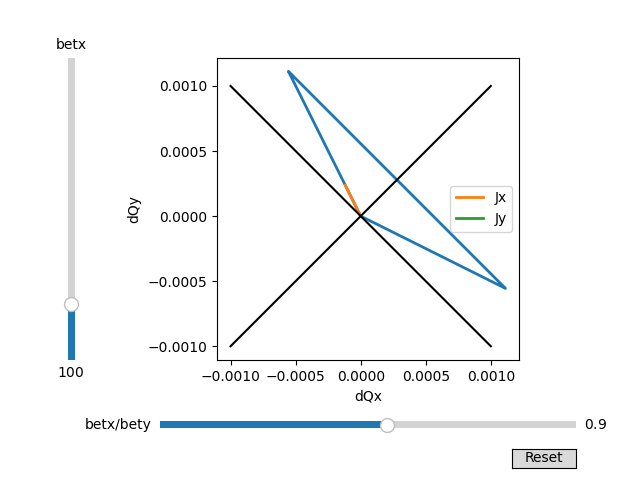

In [8]:
%matplotlib widget


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)




# Define initial parameters
init_amplitude = 5
init_frequency = 3


def triangle(r,betx):
    return dtune.DQx_DQy_octupole( tracked['coord']['x_sig'],
                                tracked['coord']['y_sig'],
                                #betxy   = [betx,betx/r],
                                betxy   = [betx*r,betx],
                                emittxy = np.array([2.3e-6,2.3e-6])/gamma0,
                                k1l     = 0,
                                k3l     = -100*mo_df.loc[0,'k3l'])

init_r    = 1
init_betx = 100

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
dQx,dQy = triangle(init_r,init_betx)
line, = ax.plot(dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']], lw=2)
line2, = ax.plot(dQx.loc[tracked['ctour_idx'][:10]],dQy.loc[tracked['ctour_idx'][:10]], lw=2,label='Jx')
line3, = ax.plot(dQx.loc[tracked['ctour_idx'][-10:]],dQy.loc[tracked['ctour_idx'][-10:]], lw=2,label='Jy')
plt.plot([-1e-3,1e-3],[-1e-3,1e-3],color='k')
plt.plot([-1e-3,1e-3],[1e-3,-1e-3],color='k')
plt.axis('square')
# plt.xlim(np.array(Qx_lim)-Qx_0)
# plt.ylim(np.array(Qy_lim)-Qy_0)
ax.legend()
ax.set_xlabel('dQx')
ax.set_ylabel('dQy')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
ax1 = fig.add_axes([0.25, 0.1, 0.65, 0.03])
r_slider = Slider(
    ax=ax1,
    label='betx/bety',
    valmin=-10,
    valmax=10,
    valstep = np.linspace(-10,10,100),
    valinit=init_r,
)

# Make a vertically oriented slider to control the amplitude
ax2 = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
betx_slider = Slider(
    ax=ax2,
    label="betx",
    valmin=10,
    valmax=500,
    valinit=init_betx,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    dQx,dQy = triangle(r_slider.val,betx_slider.val)
    line.set_xdata(dQx.loc[tracked['ctour_idx']])
    line.set_ydata(dQy.loc[tracked['ctour_idx']])

    line2.set_xdata(dQx.loc[tracked['ctour_idx'][:10]])
    line2.set_ydata(dQy.loc[tracked['ctour_idx'][:10]])
    fig.canvas.draw_idle()


# register the update function with each slider
r_slider.on_changed(update)
betx_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    r_slider.reset()
    betx_slider.reset()
button.on_clicked(reset)

plt.show()